In [186]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
import math
import statsmodels.api as sm
plt.rcParams['savefig.dpi'] = 600
from matplotlib import cm
import matplotlib.colors as colors
from matplotlib.patches import Rectangle
from matplotlib.patches import Polygon
import matplotlib.gridspec as gridspec

## Importing the data

In [188]:
# Filtered selection coefficients for the F3-F4 150 paired-end libraries
s_filtered_150 = pd.read_csv("s_final/Final_s_150_F3F4.csv", index_col=None)

# Simulation results
sim_s_app = pd.read_csv("Sim_results/Normal_005/s_apparent_Normal_005.csv", index_col=None)

# Final selection coefficients from 300 paired-end sequencing
s_no_out_300 = pd.read_csv("Supp_data/s_300_5FC_no_out.csv", index_col=None)


## Preparing the data

### Selection coefficients from 150 paired-end sequencing of the 5-FC screen

In [191]:
# Keeping only columns of interest
s_filtered_150 = s_filtered_150[['Library', 'Genotype', 's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref',
                                'Alias', 'Bio_rep', 'Tech_rep', 'With_CDS_spikeins', 'Condition',
                                 'Mutation type', 'Position', 'In F3F4']].copy()
# Kepping only F3F4 single mutants
s_filtered_150 = s_filtered_150[s_filtered_150['In F3F4']].copy().reset_index(drop=True)

# Keeping only the samples with 5-FC and without spike-ins
s_filtered_150 = s_filtered_150[(s_filtered_150['With_CDS_spikeins'] == False) & (s_filtered_150['Condition'] == 'WITH_5FC')].copy().reset_index(drop=True)

# Adding a "samp_id" column
s_filtered_150['samp_id'] = s_filtered_150['Bio_rep'].astype('str') + s_filtered_150['Tech_rep']

In [192]:
# Making a dataframe with a different column for each library
s_filtered_150 = s_filtered_150.sort_values(by='samp_id').copy().reset_index(drop=True)
s_150_bylib = pd.pivot(s_filtered_150, index='Genotype', columns='samp_id', values='s_T0toT3_Ref')

In [193]:
# Computing the matrix of pearson correlation coefficients 
pearson_mat_150 = pd.DataFrame(index=s_150_bylib.columns, columns=s_150_bylib.columns)

for lib_a in s_150_bylib.columns:

    for lib_b in s_150_bylib.columns:

        data_corr = s_150_bylib.dropna(subset=[lib_a, lib_b]).copy().reset_index(drop=True)

        corr_val = stats.pearsonr(data_corr[lib_a], data_corr[lib_b])[0]

        pearson_mat_150.at[lib_a, lib_b] = corr_val

In [194]:
pearson_mat_150

samp_id,1A,1B,2A,2B,3A,3B,4A,4B
samp_id,,,,,,,,
1A,1.0,0.736055,0.184397,0.169919,0.120326,0.121351,0.183354,0.187425
1B,0.736055,1.0,0.18841,0.153971,0.160238,0.148688,0.204734,0.201797
2A,0.184397,0.18841,1.0,0.847599,0.130191,0.173318,0.115918,0.141519
2B,0.169919,0.153971,0.847599,1.0,0.101172,0.134991,0.079716,0.127549
3A,0.120326,0.160238,0.130191,0.101172,1.0,0.799971,0.150036,0.168504
3B,0.121351,0.148688,0.173318,0.134991,0.799971,1.0,0.173224,0.159591
4A,0.183354,0.204734,0.115918,0.079716,0.150036,0.173224,1.0,0.795138
4B,0.187425,0.201797,0.141519,0.127549,0.168504,0.159591,0.795138,1.0


In [195]:
# We also need a long df of selection coefficients where the time interval is in a column (to be used as hue)

time_int_rename = {'s_T0toT1_Ref':'T0-T1', 's_T0toT2_Ref':'T0-T2', 's_T0toT3_Ref':'T0-T3'}
s_150_by_timepoint = s_filtered_150[['samp_id', 'Genotype', 's_T0toT1_Ref', 's_T0toT2_Ref', 's_T0toT3_Ref']].copy()
s_150_by_timepoint = s_filtered_150.rename(columns=time_int_rename)
s_150_by_timepoint = pd.melt(s_150_by_timepoint, id_vars=['samp_id', 'Genotype'],
                            value_vars=['T0-T1', 'T0-T2', 'T0-T3'],
                            var_name='Time interval', value_name='Selection coefficients')

### Simulation results

In [197]:
# First dropping the WT
sim_s_app = sim_s_app[sim_s_app['Genotype'] != 'WT'].copy().reset_index(drop=True)

In [198]:
# Obtaining a new dataframe with doifferent columns for each library
sim_s_app['Library'] = sim_s_app['Library'].apply(lambda x: ''.join(x.split('-')))
sim_s_app = sim_s_app.sort_values(by='Library')

sim_s_bylib = pd.pivot(sim_s_app, index='Genotype', columns='Library', values='s_T0toT3')

In [199]:
# Computing the matrix of correlation coefficients
pearson_mat_sim = pd.DataFrame(index=sim_s_bylib.columns, columns=sim_s_bylib.columns)

for lib_a in sim_s_bylib.columns:

    for lib_b in sim_s_bylib.columns:

        data_corr = sim_s_bylib.dropna(subset=[lib_a, lib_b]).copy().reset_index(drop=True)

        corr_val = stats.pearsonr(data_corr[lib_a], data_corr[lib_b])[0]

        pearson_mat_sim.at[lib_a, lib_b] = corr_val

In [200]:
pearson_mat_sim

Library,1A,1B,2A,2B,3A,3B,4A,4B
Library,,,,,,,,
1A,1.0,0.981411,-0.015814,-0.018218,0.074654,0.069929,-0.020159,-0.017184
1B,0.981411,1.0,-0.009351,-0.010879,0.069377,0.065955,-0.017305,-0.014635
2A,-0.015814,-0.009351,1.0,0.979396,-0.004924,-0.002744,-0.010711,-0.003109
2B,-0.018218,-0.010879,0.979396,1.0,-0.00703,-0.004523,-0.010655,-0.003785
3A,0.074654,0.069377,-0.004924,-0.00703,1.0,0.981209,-0.006467,0.006615
3B,0.069929,0.065955,-0.002744,-0.004523,0.981209,1.0,-0.009254,0.004306
4A,-0.020159,-0.017305,-0.010711,-0.010655,-0.006467,-0.009254,1.0,0.982352
4B,-0.017184,-0.014635,-0.003109,-0.003785,0.006615,0.004306,0.982352,1.0


In [201]:
# Making a long df of selection coefficients where the time interval is in a column (to be used as hue)
time_sim_rename = {'s_T0toT1':'T0-T1', 's_T0toT2':'T0-T2', 's_T0toT3':'T0-T3'}
s_sim_by_timepoint = sim_s_app[['Library', 'Genotype', 's_T0toT1', 's_T0toT2', 's_T0toT3']].copy()
s_sim_by_timepoint = s_sim_by_timepoint.rename(columns=time_sim_rename)
s_sim_by_timepoint = pd.melt(s_sim_by_timepoint, id_vars=['Library', 'Genotype'],
                            value_vars=['T0-T1', 'T0-T2', 'T0-T3'],
                            var_name='Time interval', value_name='Selection coefficients')

### Selection coefficients from 300 paired-end sequencing

In [203]:
s_sec_300 = s_no_out_300[['Genotype', 'Position', 'In F3F4', 'Mutation type',
                         'Bio_rep', 'Tech_rep', 'FCY1_position', 's_T0toT3_Ref']].copy()

s_sec_300 = s_sec_300[s_sec_300['In F3F4'] == False].copy().reset_index(drop=True)
s_sec_300['samp_id'] = s_sec_300['Bio_rep'].astype('str') + s_sec_300['Tech_rep']
s_sec_300 = s_sec_300.sort_values(by='samp_id').reset_index(drop=True)

# Keeping only mutants within the FCY1 CDS
s_sec_300 = s_sec_300[s_sec_300['FCY1_position'] > 0].copy().reset_index(drop=True)

In [204]:
# s of secondary mutants in simulations
np.median(s_sec_300[s_sec_300['s_T0toT3_Ref'] > 0.5]['s_T0toT3_Ref'])

0.5875887965974519

In [205]:
# Computing medians, min and max for each mutant
s_sec_medians = s_sec_300.drop(columns=['Bio_rep', 'Tech_rep', 'samp_id']).groupby(by=['Genotype', 'Position', 'In F3F4',
                                                                                       'Mutation type', 'FCY1_position'],
                                                                                  as_index=False).median()

s_sec_min = s_sec_300.drop(columns=['Bio_rep', 'Tech_rep', 'samp_id']).groupby(by=['Genotype', 'Position', 'In F3F4',
                                                                                   'Mutation type', 'FCY1_position'],
                                                                               as_index=False).min()
s_sec_min = s_sec_min.rename(columns={'s_T0toT3_Ref': 'Min_s'})

s_sec_max = s_sec_300.drop(columns=['Bio_rep', 'Tech_rep', 'samp_id']).groupby(by=['Genotype', 'Position', 'In F3F4',
                                                                                   'Mutation type', 'FCY1_position'],
                                                                               as_index=False).max()
s_sec_max = s_sec_max.rename(columns={'s_T0toT3_Ref': 'Max_s'})

s_sec_medians = pd.merge(s_sec_medians, s_sec_min, on=['Genotype', 'Position', 'In F3F4', 'Mutation type', 'FCY1_position'], how='outer')
s_sec_medians = pd.merge(s_sec_medians, s_sec_max, on=['Genotype', 'Position', 'In F3F4', 'Mutation type', 'FCY1_position'], how='outer')

In [206]:
# Obtaining subsets and diffs (for error bars) for each type of mutation
sec_sub = s_sec_medians[s_sec_medians['Mutation type'] == 'Substitution'].copy().reset_index(drop=True)
sec_sub['Mutation type'] = 'Sub'
sub_err =  np.array([sec_sub['s_T0toT3_Ref'] - sec_sub['Min_s'],
                     sec_sub['Max_s'] - sec_sub['s_T0toT3_Ref']])

sec_ins = s_sec_medians[s_sec_medians['Mutation type'] == 'Insertion'].copy().reset_index(drop=True)
sec_ins['Mutation type'] = 'Ins'
ins_err =  np.array([sec_ins['s_T0toT3_Ref'] - sec_ins['Min_s'],
                     sec_ins['Max_s'] - sec_ins['s_T0toT3_Ref']])

sec_del = s_sec_medians[s_sec_medians['Mutation type'] == 'Deletion'].copy().reset_index(drop=True)
sec_del['Mutation type'] = 'Del'
del_err =  np.array([sec_del['s_T0toT3_Ref'] - sec_del['Min_s'],
                     sec_del['Max_s'] - sec_del['s_T0toT3_Ref']])

mut_palette = {'Sub': cm.tab10.colors[9], 
               'Ins': cm.tab20b.colors[1],
               'Del': cm.tab10.colors[3]}

## Assembling the figure

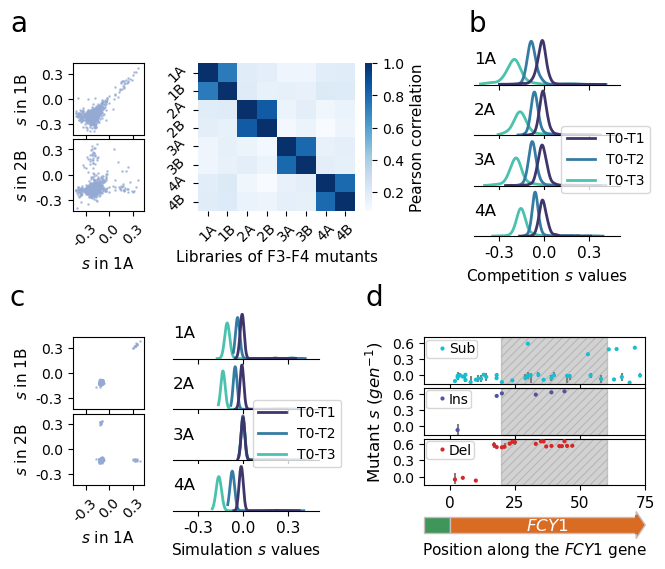

In [208]:
fig = plt.figure(constrained_layout=False, figsize=(6.48, 4.98))

# First row, for 150 paired-end artifacts
gs1 = fig.add_gridspec(nrows=11, ncols=26, left=0, right=1, bottom=0.45, top=1 )
# Second row, for simulation artifacts and 300 paired-end s coefficients
gs2 = fig.add_gridspec(nrows=9, ncols=26, left=0, right=1, bottom=0, top=0.45 )

# axes for correlation matrix with insets
ax1 = fig.add_subplot(gs1[1:4, 3:6])
ax2 = fig.add_subplot(gs1[4:7, 3:6], sharex=ax1, sharey=ax1)
ax3 = fig.add_subplot(gs1[1:7, 8:16])

# axes for distributions of selection coefficients
ax4 = fig.add_subplot(gs1[0:2, 19:25])
ax5 = fig.add_subplot(gs1[2:4, 19:25], sharex=ax4)
ax6 = fig.add_subplot(gs1[4:6, 19:25], sharex=ax4)
ax7 = fig.add_subplot(gs1[6:8, 19:25], sharex=ax4)

# test adding second row
#ax_test = fig.add_subplot(gs2[0:8, 3:26])

# axes for correlation scatterplots for simulations
ax8 = fig.add_subplot(gs2[1:4, 3:6], sharex=ax1, sharey=ax1)
ax9 = fig.add_subplot(gs2[4:7, 3:6], sharex=ax1, sharey=ax1)

# axes for distributions from simulations
ax10 = fig.add_subplot(gs2[0:2, 7:13], sharex=ax4)
ax11 = fig.add_subplot(gs2[2:4, 7:13], sharex=ax4)
ax12 = fig.add_subplot(gs2[4:6, 7:13], sharex=ax4)
ax13 = fig.add_subplot(gs2[6:8, 7:13], sharex=ax4)

# ax for secondary mutations in FCY1
ax14 = fig.add_subplot(gs2[1:3, 17:26])
ax15 = fig.add_subplot(gs2[3:5, 17:26], sharex=ax14, sharey=ax14)
ax16 = fig.add_subplot(gs2[5:7, 17:26], sharex=ax14, sharey=ax14)

# Filling the axes

# Panel A
ax1.scatter(s_150_bylib['1A'], s_150_bylib['1B'], c="#95aad3", s=0.75, alpha=0.65)
#ax1.plot([0, 1], [0, 1], transform=ax1.transAxes, linestyle='dotted', color='grey', zorder=0)
ax2.scatter(s_150_bylib['1A'], s_150_bylib['2B'], c="#95aad3", s=0.75, alpha=0.65)
#ax2.plot([0, 1], [0, 1], transform=ax2.transAxes, linestyle='dotted', color='grey', zorder=0)

sns.heatmap(data=pearson_mat_150.infer_objects(), ax=ax3, cmap='Blues')
cbar_blue = ax3.collections[0].colorbar
cbar_blue.set_label('Pearson correlation', fontsize=11)

for ax_scatter in [ax1, ax2]:
    ax_scatter.set_xticks([-0.30, 0.0, 0.30], labels=[-0.30, 0.0, 0.30], fontsize=10)
    ax_scatter.tick_params(axis='x', labelrotation=45)
    ax_scatter.set_yticks([-0.30, 0.0, 0.30], labels=[-0.30, 0.0, 0.30], fontsize=10)

ax2.set_xlabel(r"$s$ in 1A", fontsize=11)
ax1.set_ylabel(r"$s$ in 1B", fontsize=11)
ax2.set_ylabel(r"$s$ in 2B", fontsize=11)

ax3.set_xlabel('Libraries of F3-F4 mutants', fontsize=11)
ax3.set_ylabel('')
ax3.tick_params(axis='y', labelrotation=45)
ax3.tick_params(axis='x', labelrotation=45)

# Panel B
axes_b = [ax4, ax5, ax6, ax7]
for row_num, lib_id in enumerate(['1A', '2A', '3A', '4A']):
    s_subset = s_150_by_timepoint[s_150_by_timepoint['samp_id'] == lib_id].copy().reset_index(drop=True)

    axes_b[row_num].spines['left'].set_visible(False)
    axes_b[row_num].spines['right'].set_visible(False)
    axes_b[row_num].spines['top'].set_visible(False)

    axes_b[row_num].annotate(f'{lib_id}', (0, 0.45), xycoords='axes fraction', fontsize=12)
    
    if row_num != 3:
        axes_b[row_num].tick_params(left=False, labelleft=False, bottom=True, labelbottom=False, top=False, labeltop=False,
                                    right=False, labelright=False)
    elif row_num == 3:
        axes_b[row_num].tick_params(left=False, labelleft=False, bottom=True, labelbottom=True, top=False, labeltop=False,
                                    right=False, labelright=False)

    if row_num == 0:
        kde_data = sns.kdeplot(s_subset, x='Selection coefficients', hue='Time interval',
                               palette='mako', ax=axes_b[row_num], cut=0, linewidth=2)

    else:
        sns.kdeplot(s_subset, x='Selection coefficients', hue='Time interval',
                    palette='mako', ax=axes_b[row_num], cut=0, linewidth=2, legend=False)

ax4.set_zorder(3)
ax4.get_legend().set(title=None, bbox_to_anchor=(1.25, -0.75), loc='upper right')

ax7.set_xlabel(r"Competition $s$ values", fontsize=11)
ax7.tick_params(axis='x', labelsize=11)
ax7.set_xticks([-0.30, 0.0, 0.30], labels=[-0.30, 0.0, 0.30])


# Panel C
ax8.scatter(sim_s_bylib['1A'], sim_s_bylib['1B'], c="#95aad3", s=0.75, alpha=0.65)
#ax8.plot([0, 1], [0, 1], transform=ax8.transAxes, linestyle='dotted', color='grey', zorder=0)
ax9.scatter(sim_s_bylib['1A'], sim_s_bylib['2B'], c="#95aad3", s=0.75, alpha=0.65)
#ax9.plot([0, 1], [0, 1], transform=ax9.transAxes, linestyle='dotted', color='grey', zorder=0)

for ax_scatter_sim in [ax8, ax9]:
    ax_scatter_sim.set_xticks([-0.30, 0.0, 0.30], labels=[-0.30, 0.0, 0.30], fontsize=10)
    ax_scatter_sim.tick_params(axis='x', labelrotation=45)
    ax_scatter_sim.set_yticks([-0.30, 0.0, 0.30], labels=[-0.30, 0.0, 0.30], fontsize=10)

ax8.tick_params(axis='x', labelsize=5)
ax9.set_xlabel(r"$s$ in 1A", fontsize=11)
ax8.set_ylabel(r"$s$ in 1B", fontsize=11)
ax9.set_ylabel(r"$s$ in 2B", fontsize=11)

axes_c = [ax10, ax11, ax12, ax13]
for row_num, lib_id in enumerate(['1A', '2A', '3A', '4A']):
    s_subset = s_sim_by_timepoint[s_sim_by_timepoint['Library'] == lib_id].copy().reset_index(drop=True)

    axes_c[row_num].spines['left'].set_visible(False)
    axes_c[row_num].spines['right'].set_visible(False)
    axes_c[row_num].spines['top'].set_visible(False)

    axes_c[row_num].annotate(f'{lib_id}', (0, 0.45), xycoords='axes fraction', fontsize=12)
    
    if row_num != 3:
        axes_c[row_num].tick_params(left=False, labelleft=False, bottom=True, labelbottom=False, top=False, labeltop=False,
                                    right=False, labelright=False)
    elif row_num == 3:
        axes_c[row_num].tick_params(left=False, labelleft=False, bottom=True, labelbottom=True, top=False, labeltop=False,
                                    right=False, labelright=False)

    if row_num == 0:
        kde_sim = sns.kdeplot(s_subset, x='Selection coefficients', hue='Time interval',
                                 palette='mako', ax=axes_c[row_num], cut=0, linewidth=2)

    else:
        sns.kdeplot(s_subset, x='Selection coefficients', hue='Time interval',
                    palette='mako', ax=axes_c[row_num], cut=0, linewidth=2, legend=False)

ax10.set_zorder(3)
ax10.get_legend().set(title=None, bbox_to_anchor=(1.20, -0.75), loc='upper right')
ax13.set_xlabel(r"Simulation $s$ values", fontsize=11)
ax13.tick_params(axis='x', labelsize=11)

# Panel D
sns.stripplot(data=sec_sub, x='FCY1_position', y='s_T0toT3_Ref', hue='Mutation type', 
              ax=ax14, s=3, palette=mut_palette, edgecolor='None', native_scale=True)
ax14.errorbar(sec_sub['FCY1_position'], sec_sub['s_T0toT3_Ref'], yerr=sub_err,
              fmt='none', zorder=0, ecolor='grey', linewidth=1.5)
h14, l14 = ax14.get_legend_handles_labels()
ax14.legend(h14, l14, handletextpad=-0.5, title=None, loc="upper left",
            borderaxespad=0.15, borderpad=0.15)
ax14.set_xlim(left=-10, right=75)  # Since the furthest mut is at 75 (see below)
ax14.tick_params(axis='x', which='both', labelbottom=False)

sns.stripplot(data=sec_ins, x='FCY1_position', y='s_T0toT3_Ref', hue='Mutation type', 
              ax=ax15, s=3, palette=mut_palette, edgecolor='None', native_scale=True)
ax15.errorbar(sec_ins['FCY1_position'], sec_ins['s_T0toT3_Ref'], yerr=ins_err,
              fmt='none', zorder=0, ecolor='grey', linewidth=1.5)
h15, l15 = ax15.get_legend_handles_labels()
ax15.legend(h15, l15, handletextpad=-0.5, title=None, loc="upper left",
            borderaxespad=0.15, borderpad=0.15)
ax15.tick_params(axis='x', which='both', labelbottom=False)

sns.stripplot(data=sec_del, x='FCY1_position', y='s_T0toT3_Ref', hue='Mutation type', 
              ax=ax16, s=3, palette=mut_palette, edgecolor='None', native_scale=True)
ax16.errorbar(sec_del['FCY1_position'], sec_del['s_T0toT3_Ref'], yerr=del_err,
              fmt='none', zorder=0, ecolor='grey', linewidth=1.5)
h16, l16 = ax16.get_legend_handles_labels()
ax16.legend(h16, l16, handletextpad=-0.5, title=None, loc="upper left",
            borderaxespad=0.15, borderpad=0.15)

ax14.set_ylim(bottom=-0.16424006843859074, top=0.70)  # Freezing ylims before adding annotations

ax16.add_patch(Rectangle((-10, -0.75), 10, -0.30, facecolor='#3f955a', edgecolor='#c8bdbd', clip_on=False))  # F4
ax16.add_patch(Rectangle((0, -0.75), 71.5, -0.30, facecolor='#d45400dc', edgecolor='#c8bdbd', clip_on=False))  # FCY1
ax16.add_patch(Polygon([[71.5, -0.65], [71.5, -1.15], [75, -0.90]], facecolor='#d45400dc', edgecolor='#c8bdbd', clip_on=False))

ax16.plot([71.5, 71.5], [-1.045525, -0.730], c='white', zorder=2, linewidth=1.45, clip_on=False)
ax16.plot([71.5, 71.5], [-1.045525, -0.730], c='#d45400dc', zorder=3, linewidth=1.50, clip_on=False)

ax16.annotate(r"$\it{FCY1}$", (37.5, -0.91), annotation_clip=False, color='white', ha='center', va='center',
              fontsize=12, zorder=1)

for ax_muts in [ax14, ax15, ax16]:
    ax_muts.tick_params(axis='x', labelsize=11)
    ax_muts.set_yticks([0.0, 0.3, 0.6], labels=[0.0, 0.3, 0.6], fontsize=10)
    # Adding the 40 bp of the homology arm which was not sequenced oin 150 paired-end
    ax_muts.add_patch(Rectangle((19.5, -0.16424006843859074), 41, (0.16424006843859074+0.70), color='grey', hatch='////', 
                                hatch_linewidth=0.75, alpha=0.35, clip_on=False, zorder=2))

ax14.set_ylabel('')
ax15.set_ylabel(r"Mutant $s$ ($gen^{-1}$)", fontsize=12)
ax16.set_ylabel('')
ax16.set_xlabel(r"Position along the $\it{FCY1}$ gene", labelpad=21.5, fontsize=11)

# Adding subfigure labels
ax1.annotate('a', (-1.25, 0.80), annotation_clip=False, fontsize=20)
ax4.annotate('b', (-0.5, 5.375), annotation_clip=False, fontsize=20)
ax8.annotate('c', (-1.25, 0.80), annotation_clip=False, fontsize=20)
ax14.annotate('d', (-32.5, 1.30), annotation_clip=False, fontsize=20)

fig3 = plt.gcf()
fig3.savefig(f"Final_figs/Fig3.tiff", bbox_inches='tight')

In [209]:
s_sim_by_timepoint[['Library', 'Time interval', 'Selection coefficients']].copy().groupby(by=['Library', 'Time interval'], as_index=False).median()

,Library,Time interval,Selection coefficients
0,1A,T0-T1,-0.005590
1,1A,T0-T2,-0.035389
2,1A,T0-T3,-0.104990
3,1B,T0-T1,-0.005717
4,1B,T0-T2,-0.038411
5,1B,T0-T3,-0.110089
6,2A,T0-T1,-0.006882
7,2A,T0-T2,-0.051943
8,2A,T0-T3,-0.133477
9,2B,T0-T1,-0.007154


In [210]:
s_150_by_timepoint[['samp_id', 'Time interval', 'Selection coefficients']].copy().groupby(by=['samp_id', 'Time interval'], as_index=False).median()

,samp_id,Time interval,Selection coefficients
0,1A,T0-T1,-0.013686
1,1A,T0-T2,-0.081979
2,1A,T0-T3,-0.198734
3,1B,T0-T1,-0.007919
4,1B,T0-T2,-0.085357
5,1B,T0-T3,-0.190745
6,2A,T0-T1,-0.005362
7,2A,T0-T2,-0.062007
8,2A,T0-T3,-0.156650
9,2B,T0-T1,-0.006503


In [211]:
s_150_by_timepoint.columns

Index(['samp_id', 'Genotype', 'Time interval', 'Selection coefficients'], dtype='object')

In [212]:
np.median(sim_s_app['s_T0toT3'])

-0.1185565389343662

In [213]:
s_sec_medians[s_sec_medians['s_T0toT3_Ref'] >= 0.2].sort_values(by='FCY1_position', ascending=False)

,Genotype,Position,In F3F4,Mutation type,FCY1_position,s_T0toT3_Ref,Min_s,Max_s
63,S-276_1nt_TtoC,276,False,Substitution,71,0.509080,0.509080,0.509080
60,S-269_1nt_GtoC,269,False,Substitution,64,0.483972,0.483972,0.483972
58,S-266_1nt_GtoT,266,False,Substitution,61,0.478691,0.478691,0.478691
55,S-258_1nt_CtoG,258,False,Substitution,53,0.388001,0.375452,0.400550
19,D-252_1nt_Ato-,252,False,Deletion,47,0.572710,0.558367,0.587052
18,D-250_1nt_Gto-,250,False,Deletion,45,0.571366,0.536384,0.575694
17,D-249_1nt_Tto-,249,False,Deletion,44,0.657810,0.653057,0.662563
26,I-248_1nt_-toT,248,False,Insertion,44,0.641582,0.625618,0.657545
16,D-248_1nt_Ato-,248,False,Deletion,43,0.565663,0.546174,0.585152
15,D-247_1nt_Tto-,247,False,Deletion,42,0.568404,0.564871,0.571936


In [214]:
np.median(s_sec_medians[s_sec_medians['s_T0toT3_Ref'] >= 0.2]['s_T0toT3_Ref'])

0.5727098787220806

In [215]:
np.max(s_sec_medians['Max_s'])

0.6853330225875917